In [18]:
import numpy as np
import pandas as pd
import pickle
import requests
from timeit import default_timer as timer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [19]:
movies = pickle.load(open("../pickle/movies.pkl", "rb"))
cosine = pickle.load(open("../pickle/cosine_sim.pkl", "rb"))
knn_similarity = pickle.load(open("../pickle/knn.pkl", "rb"))
lsa = pickle.load(open("../pickle/lsa.pkl", "rb"))

In [20]:
def recommendMovieCosine(selected_movies):
    start = timer()

    # Find the index of the movie that matches the title
    index = movies[movies['Series_Title'] == selected_movies].index[0]
    distance = sorted(list(enumerate(cosine[index])), reverse=True, key=lambda vector: vector[1])

    end = timer()

    time_executed = (end - start) * 1000
    return time_executed


In [21]:
def recommendMovieKNN(selected_movies):

    # Start the timer
    start = timer()

    index = movies[movies['Series_Title'] == selected_movies].index[0]
    
    # Reduce the dimensionality of the input movie (same transformation as training)
    pca = PCA(n_components=1000)  # Use the number of components you want
    similarity_reduced = pca.fit_transform(knn_similarity)  # Apply PCA to reduce dimensionality
    movie_reduced = pca.transform(knn_similarity[index].reshape(1, -1))
    
    # Perform the k-nearest neighbors search
    knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
    knn.fit(similarity_reduced)
    distances, indices = knn.kneighbors(movie_reduced, n_neighbors=5)
    indices = indices.flatten()  # Flatten the indices to use for Pandas indexing

    end = timer()

    time_executed = (end - start) * 1000
    return time_executed

In [22]:
# LSA
def euclidean_distance(vec1, vec2):
    return np.sqrt(np.sum((vec1 - vec2) ** 2))

def find_similar_movies(target_vec, lsa):
    distances = []
    for idx, movie_vec in enumerate(lsa):
        diff = euclidean_distance(target_vec, movie_vec)
        distances.append((idx, diff))
    
    # Sort distances in ascending order
    distances.sort(key=lambda x: x[1])
    
    # Return similar movies
    return distances[:10]

def recommendMovieLSA(selected_movies):
    start = timer()

    # Find the index of the movie that matches the title
    index = movies[movies['Series_Title'] == selected_movies].index[0]

    # Perform similarity search on the full dataset
    target_vec = lsa[index]
    similar_movies = find_similar_movies(target_vec, lsa)

    end = timer()

    time_executed = (end - start) * 1000
    return time_executed

In [23]:
all_movies = movies["Series_Title"].to_list()

print(all_movies[0])
print(len(all_movies))

The Shawshank Redemption
1000


In [24]:
movies.head()

,Series_Title,Poster_Link
0,The Shawshank Redemption,https://m.media-amazon.com/images/M/MV5BMDFkYT...
1,The Godfather,https://m.media-amazon.com/images/M/MV5BM2MyNj...
2,The Dark Knight,https://m.media-amazon.com/images/M/MV5BMTMxNT...
3,The Godfather: Part II,https://m.media-amazon.com/images/M/MV5BMWMwMG...
4,12 Angry Men,https://m.media-amazon.com/images/M/MV5BMWU4N2...


In [25]:
# calculate every movies recommended time using cosine similarity algorithm
cosine_times = []
for i in all_movies:
    cosine_time = recommendMovieCosine(i)
    cosine_times.append(cosine_time)

print(cosine_times[0])
print(len(cosine_times))

1.2863000010838732
1000


In [28]:
# calculate every movies recommended time using KNN algorithm
knn_times = []
for i in all_movies:
    knn_time = recommendMovieKNN(i)
    knn_times.append(knn_time)

print(knn_times[0])
print(len(knn_times))

517.4295000033453
1000


In [27]:
# calculate every movies recommended time using LSA algorithm
lsa_times = []
for i in all_movies:
    lsa_time = recommendMovieLSA(i)
    lsa_times.append(lsa_time)

print(lsa_times[0])
print(len(lsa_times))

29.55880000081379
1000


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# Create a DataFrame to organize the data
data = pd.DataFrame({
    'Movies': all_movies,
    'Cosine Similarity': cosine_times,
    'KNN': knn_times,
    'LSA': lsa_times
})

In [34]:
data.head()

,Movies,Cosine Similarity,KNN,LSA
0,The Shawshank Redemption,1.2863,517.4295,29.5588
1,The Godfather,1.0364,476.4936,23.2702
2,The Dark Knight,2.2321,624.0168,18.9918
3,The Godfather: Part II,2.6321,796.3446,20.8690
4,12 Angry Men,1.3564,1002.4917,24.2010


In [35]:
# Melt the DataFrame to a long format suitable for plotting
data_melted = data.melt(id_vars='Movies', var_name='Algorithm', value_name='Execution Time')

In [36]:
data_melted.head()

,Movies,Algorithm,Execution Time
0,The Shawshank Redemption,Cosine Similarity,1.2863
1,The Godfather,Cosine Similarity,1.0364
2,The Dark Knight,Cosine Similarity,2.2321
3,The Godfather: Part II,Cosine Similarity,2.6321
4,12 Angry Men,Cosine Similarity,1.3564


c:\Users\Asus\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


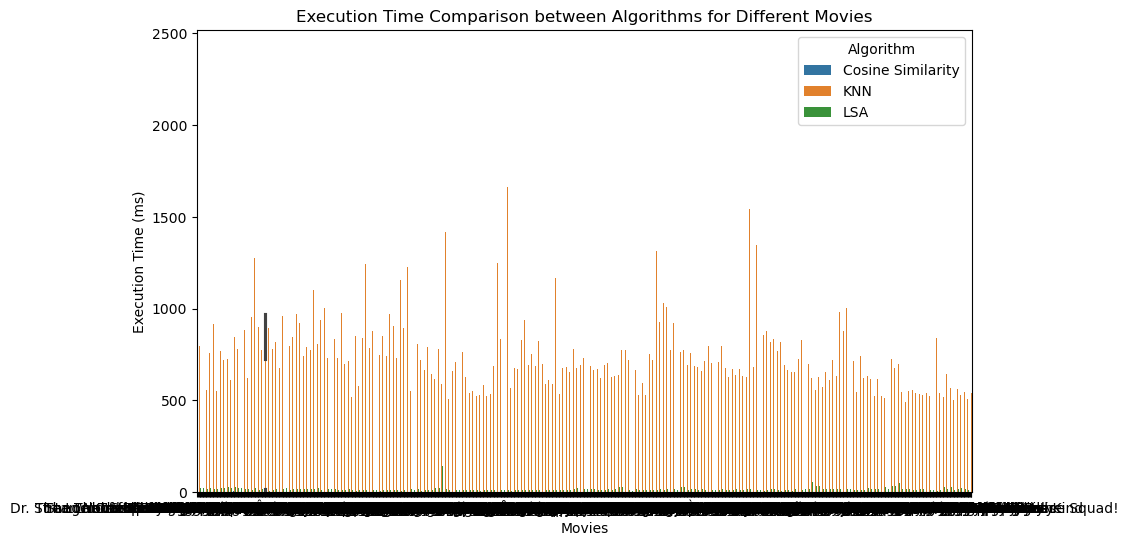

In [37]:
# Set up the plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Movies', y='Execution Time', hue='Algorithm', data=data_melted)

# Add title and labels
plt.title('Execution Time Comparison between Algorithms for Different Movies')
plt.ylabel('Execution Time (ms)')
plt.xlabel('Movies')

plt.show()

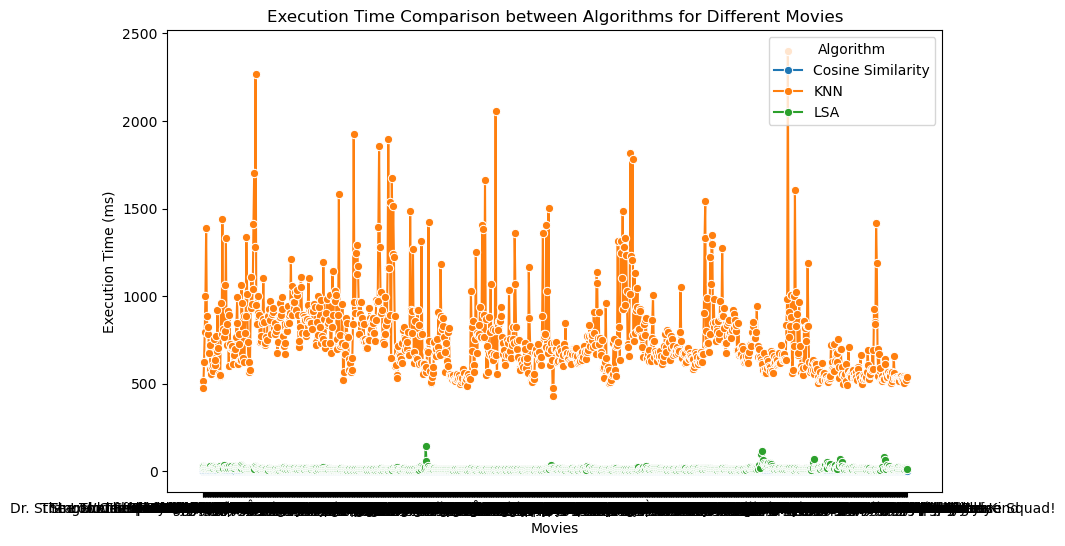

In [38]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='Movies', y='Execution Time', hue='Algorithm', data=data_melted, marker='o')

# Add title and labels
plt.title('Execution Time Comparison between Algorithms for Different Movies')
plt.ylabel('Execution Time (ms)')
plt.xlabel('Movies')

plt.show()